# GoodReads - Content Based Recommendation System

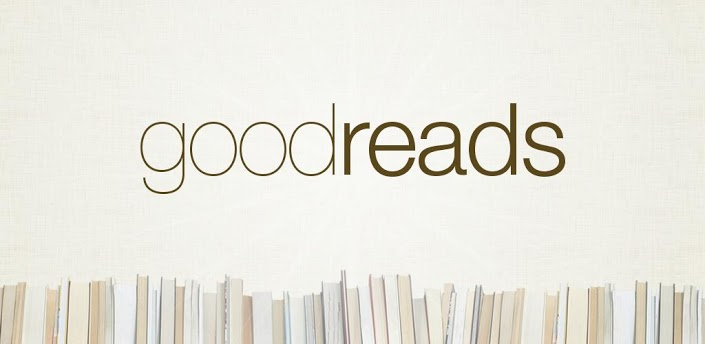


Content-based identifies the similarity between the products based on their descriptions and recommends other similar products to what the user likes, based on their previous actions or explicit feedback.

We are searching for the books similar in its content via the proxy such as books descriptions and collections of the reviews (which is more tricky as its content often reflect emotional charge and experience of the user than the book content).


### Data

In this notebook I have used the dataset scraped by Mengting Wan. 

https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home#h.p_VCP_qovwtnn1

**Citation**

1. Mengting Wan, Julian McAuley, "Item Recommendation on Monotonic Behavior Chains", in RecSys'18.  [bibtex]
2. Mengting Wan, Rishabh Misra, Ndapa Nakashole, Julian McAuley, "Fine-Grained Spoiler Detection from Large-Scale Review Corpora", in ACL'19. [bibtex]

**Inspiration**

https://towardsdatascience.com/building-a-content-based-book-recommendation-engine-9fd4d57a4da

In [2]:
### Loading Libraries

import gzip
import json
import re
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction import DictVectorizer

In [137]:
from PIL import Image
import requests
from io import BytesIO

### Define Functions

In [44]:
def load_data(file_name, head = 1000, book_ids=None):
    '''Takes a file path, number of rows to read and optionaly predefined list of books_ids to read. Returns DataFrame. '''
    count = 0
    data = []
    unique_titles =[]
    book_id_unique = []
    with gzip.open(file_name) as fin:
        for ix, l in enumerate(fin):
            d = json.loads(l)
            ## For redaing relevant for non-bookdataset
            if 'ratings_count' not in d.keys():
                if book_ids!=None:
                    if d['book_id'] in book_ids:
                        if d['book_id'] not in book_id_unique:
                            book_id_unique.append(d['book_id'])
                        data.append(d)  
                        if len(book_id_unique)==len(book_ids):
                            break
                        #count += 1
                else:
                    data.append(d)
                    count += 1
            else:
                ## Reading only poular book in english (up to defined number of unique titles)
                if (float(d['ratings_count']  or 0 )>1000.0) & ( d['language_code'] in english_books) & (d['title'] not in unique_titles):
                    d_new = { key: d[key] for key in new_keys}
                    data.append(d_new)
                    unique_titles.append(d_new['title'])
                    count += 1
            if (head is not None) and (count >= head):
                    break
    return pd.DataFrame(data)

In [30]:
stop_words = set(stopwords.words("english"))

def preprocess_text(text, stops = stop_words):
    '''Takes a text and list of stop words (by the default list of english stop words). Returns preprocessed text string.'''
    ### Remove punctionation
    tokenizer = RegexpTokenizer(r'\w+')
    ## Htmls tag pattern
    html = re.compile('<.*?>')
    ## Lower case
    text = text.lower().split()
    ## Remove stop words
    text = [word for word in text if not word in stops]
    text = " ".join(text)
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    text = html.sub(r'', text)
    return text

In [34]:
def n_gram_plot(text_array, ngram_range=(2, 2), n=20):
    '''Takes a text array, number of grams (by default 2), and number of most often occuring ngrams. Returns barplot of the top ngrams by the frequency.'''
    #TFIDF vector
    tf = TfidfVectorizer(ngram_range=ngram_range, stop_words='english', lowercase = False)
    #Transform to the sparse matrix
    tfidf = tf.fit_transform(text_array)
    Words = tfidf.sum(axis=0)
    ## Decoding words based on the index
    freq = [(word, Words[0, ix]) for word, ix in tf.vocabulary_.items()]
    freq = sorted(freq, key = lambda x: x[1], reverse=True)
    #converting into dataframe 
    ngram = pd.DataFrame(freq)
    ngram.rename(columns = {0:'ngram', 1: 'count'}, inplace = True) 
    ngram = ngram.head(n)
    ngram.plot(x ='ngram', y='count', kind = 'bar', title = "N-gram disribution for the top 20 words in the book description", figsize = (15,7), )

In [163]:
# Function for recommending books based on Book title. It takes book title and genre as an input.
def recommend_book_desc(title, show_covers=False):
    '''Takes a text string containing book title. Returns top 10 reccomendtions by the book description.'''
    ##filter by genre
    genre = books_genre.loc[books_genre['title'] == title]['main_genre'].values[0]
    df_books_genre = books_genre.loc[books_genre['main_genre'] == genre]
    df_books_genre = df_books_genre.loc[df_books_genre.astype(str).drop_duplicates(subset=['title']).index]
    df_books_genre.reset_index(level = 0, inplace = True)
    # Convert the index into series
    indices = pd.Series(df_books_genre.index, index = df_books_genre['title']).drop_duplicates()
    #Converting the book description into vectors and used bigram
    tf = TfidfVectorizer(analyzer='word', ngram_range=(3, 3), min_df = 1, stop_words='english')
    tfidf_matrix = tf.fit_transform(df_books_genre['description'])
    # Calculating the similarity measures based on Cosine Similarity
    similarity = linear_kernel(tfidf_matrix, tfidf_matrix)
    ##Get titles' indexes with the highest similarity score
    sim = list(enumerate(similarity[indices[title]]))
    sim = sorted(sim, key=lambda x: x[1], reverse=True)
    ## Take top 10
    top_indices = [i[0] for i in sim[1:10]]
    print(df_books_genre[['title']].iloc[top_indices])

    if show_covers:
        top_covers = df_books_genre[['title', 'image_url']].iloc[top_indices]
        for i in top_covers['image_url']:
            response = requests.get(i)
            img = Image.open(BytesIO(response.content))
            plt.figure()
            plt.imshow(img)

In [165]:
# Function for recommending books based on Book title. It takes book title and genre as an input.
def recommend_book_reviews(title,df = book_reviews_genre, show_covers=False):
    '''Takes a text string containing book title. Returns top 10 reccomendtions by the book review.'''
    #global rec
    # Matching the genre with the dataset and reset the index
    genre = df.loc[df['title'] == title]['main_genre'].values[0]
    ### Minimum rating
    min_rating = pd.to_numeric(df.loc[df['title'] == title]['average_rating'].values[0])-0.5
    data = df.loc[(df['main_genre'] == genre) & (pd.to_numeric(df['average_rating'][0])>=min_rating)]  
    ### Combining reviews
    data['reviews_processed_combined'] = data[['title','main_genre','review_text_processed']].groupby(['title','main_genre'])['review_text_processed'].transform(lambda x: ','.join(x))
    data = data[['title','main_genre','reviews_processed_combined','image_url']].drop_duplicates()
    data.reset_index(level = 0, inplace = True) 
    # Convert the index into series
    indices = pd.Series(data.index, index = data['title']).drop_duplicates()
    #Converting the book description into vectors and used bigram
    tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df = 1, stop_words='english')
    tfidf_matrix = tf.fit_transform(data['reviews_processed_combined'])
    # Calculating the similarity measures based on Cosine Similarity
    similarity = linear_kernel(tfidf_matrix, tfidf_matrix)
    ##Get titles' indexes with the highest similarity score
    sim = list(enumerate(similarity[indices[title]]))
    sim = sorted(sim, key=lambda x: x[1], reverse=True)
    ## Take top 10
    top_indices = [i[0] for i in sim[1:10]]
    print(data[['title']].iloc[top_indices])
    
    if show_covers:
        top_covers = data[['title', 'image_url']].iloc[top_indices]
        for i in top_covers['image_url']:
            response = requests.get(i)
            img = Image.open(BytesIO(response.content))
            plt.figure()
            plt.imshow(img)

# Load Data 

## Books

Dtaset contains detailed meta-data about 2.36M books. As reading all dataset is not feasible only sample of the first 5000 with the significant number of ratings have been read into memory.

In [39]:
DIR = '/Users/gosc/Desktop/'

In [40]:
#df = pd.read_json(DIR + 'goodreads_books.json.gz',lines=True, nrows=50)

In [41]:
### Select Columns
new_keys = ['isbn', 'text_reviews_count', 'language_code','average_rating', 'similar_books', 'description', 'authors', 'popular_shelves',
       'publication_year', 'book_id', 'ratings_count',  'title','title_without_series','url','image_url']

## English Only
english_books = ['eng', 'en-GB', 'en-US']

In [42]:
books = load_data(os.path.join(DIR, 'goodreads_books.json.gz'), head=5000)
books_ids = books['book_id'].tolist()
books.head(10)

,isbn,text_reviews_count,language_code,average_rating,similar_books,description,authors,popular_shelves,publication_year,book_id,ratings_count,title,title_without_series,url,image_url
0,0743294297,3282,eng,3.49,"[6604176, 6054190, 2285777, 82641, 7569453, 70...",Addie Downs and Valerie Adler were eight when ...,"[{'author_id': '9212', 'role': ''}]","[{'count': '7615', 'name': 'to-read'}, {'count...",2009,6066819,51184,Best Friends Forever,Best Friends Forever,https://www.goodreads.com/book/show/6066819-be...,https://s.gr-assets.com/assets/nophoto/book/11...
1,0842379428,566,eng,4.26,"[45366, 246849, 11096385, 19102466, 761197, 11...",What is Heaven really going to be like? What w...,"[{'author_id': '4862', 'role': ''}]","[{'count': '6393', 'name': 'to-read'}, {'count...",,89376,7345,Heaven,Heaven,https://www.goodreads.com/book/show/89376.Heaven,https://images.gr-assets.com/books/1406508230m...
2,0590417010,193,eng,4.43,"[834493, 452189, 140185, 1897316, 2189812, 424...",In Newbery Medalist Cynthia Rylant's classic b...,"[{'author_id': '5411', 'role': ''}]","[{'count': '450', 'name': 'to-read'}, {'count'...",1995,89378,1331,Dog Heaven,Dog Heaven,https://www.goodreads.com/book/show/89378.Dog_...,https://images.gr-assets.com/books/1360057676m...
3,1503945650,347,eng,3.69,"[23992482, 21995039, 16065476, 23006790, 14520...",An Amazon Best Book of the Year\nA Goodreads B...,"[{'author_id': '3111153', 'role': ''}]","[{'count': '9552', 'name': 'to-read'}, {'count...",2015,25317381,1537,Smoke,Smoke,https://www.goodreads.com/book/show/25317381-s...,https://images.gr-assets.com/books/1432906129m...
4,,546,en-GB,3.65,"[25653691, 18106800, 29566096, 26547917, 17934...",He wanted a baby. I needed a man.\nFaith\nThe ...,"[{'author_id': '14425920', 'role': ''}]","[{'count': '882', 'name': 'to-read'}, {'count'...",,26864719,3276,Bad Boy Daddy,Bad Boy Daddy,https://www.goodreads.com/book/show/26864719-b...,https://s.gr-assets.com/assets/nophoto/book/11...
5,0990662616,428,eng,3.71,"[20499652, 17934493, 13518102, 16210411, 17149...",The future world is at peace.\nElla Shepherd h...,"[{'author_id': '4018722', 'role': ''}]","[{'count': '9481', 'name': 'to-read'}, {'count...",2014,22642971,1525,The Body Electric,The Body Electric,https://www.goodreads.com/book/show/22642971-t...,https://images.gr-assets.com/books/1406979059m...
6,,79,eng,4.14,"[2871364, 2983654, 2212540, 3254113, 11720382,...","In the city of Atlanta, women are dying--at th...","[{'author_id': '12504', 'role': ''}]","[{'count': '12902', 'name': 'to-read'}, {'coun...",2006,6646561,1705,"Triptych (Will Trent, #1)","Triptych (Will Trent, #1)",https://www.goodreads.com/book/show/6646561-tr...,https://images.gr-assets.com/books/1492737974m...
7,0671015311,126,eng,3.72,"[612301, 713500, 166679, 27932, 4320305, 11285...",In this compelling debut of her historical mys...,"[{'author_id': '33981', 'role': ''}]","[{'count': '1607', 'name': 'to-read'}, {'count...",1998,388674,1371,"To Shield the Queen (Ursula Blanchard, #1)","To Shield the Queen (Ursula Blanchard, #1)",https://www.goodreads.com/book/show/388674.To_...,https://images.gr-assets.com/books/1325787198m...
8,1419954652,17,eng,4.26,"[351572, 362206, 362204, 357096, 2210686, 1110...",Embraced\nMarey has run from herself and from ...,"[{'author_id': '2614', 'role': ''}]","[{'count': '199', 'name': 'to-read'}, {'count'...",2007,388678,1347,"Shameless Embraces (Bound Hearts, #6-7)","Shameless Embraces (Bound Hearts, #6-7)",https://www.goodreads.com/book/show/388678.Sha...,https://s.gr-assets.com/assets/nophoto/book/11...
9,0373794061,312,eng,3.41,"[1066038, 2140655, 817976, 614751, 3287847, 17...",This is Maddy Turner's lucky day. The civilize...,"[{'author_id': '5669', 'role': ''}]","[{'count': '2472', 'name': 'to-read'}, {'count...",2008,2741853,3852,Slow Hands,Slow Hands,https://www.goodreads.com/book/show/2741853-sl...,https://s.gr-assets.com/assets/nophoto/book/11...


## Books -  EDA on the sample

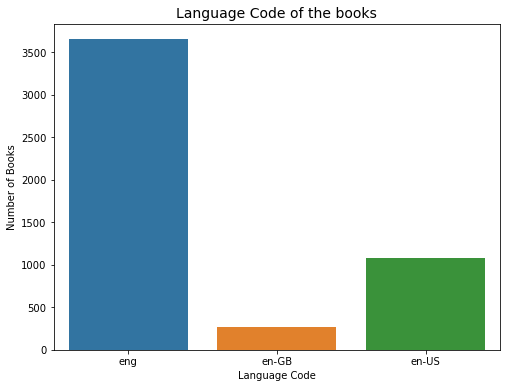

In [66]:
plt.figure(figsize=(8,6))
sns.countplot(x="language_code", data=books)
plt.title("Language Code of the books", fontsize=14)
plt.ylabel("Number of Books")
plt.xlabel("Language Code")
plt.show()

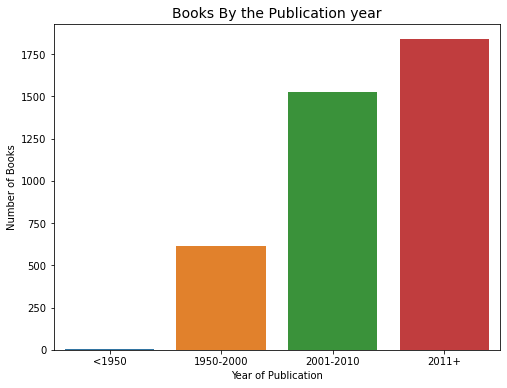

In [101]:
books['publication_year_cln'] = pd.to_numeric(books['publication_year'], errors='coerce')

year_bins = ['<1950', '1950-2000', '2001-2010', '2011+']
cut_bins = [0, 1950, 2000, 2010, 2050]
books['publication_year_bin'] = pd.cut(books['publication_year_cln'], bins=cut_bins, labels=year_bins)

plt.figure(figsize=(8,6))
sns.countplot(x="publication_year_bin", data=books)
plt.title("Books By the Publication year", fontsize=14)
plt.ylabel("Number of Books")
plt.xlabel("Year of Publication")
plt.show()

Majority of the books in the sample have ben published post 2001.

In [106]:
### Converting shelves to genres
shelves = books['popular_shelves']
genres = []
for shelve in shelves:
    shelve = [t for t in shelve if t['name'] not in ['to-read','currently-reading','books-i-own','favorites','kindle']]
    genre = shelve[0]['name']
    if len(genre) >0:
        genres.append(genre)
    else:
        genres.append('Unknown')
books['genre'] = genres

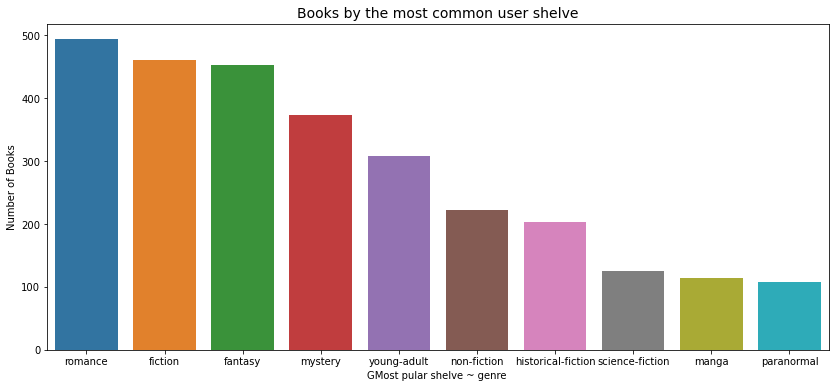

In [107]:
plt.figure(figsize=(14,6))
sns.countplot(x="genre", data=books, order=books.genre.value_counts().iloc[:10].index)
plt.title("Books by the most common user shelve", fontsize=14)
plt.ylabel("Number of Books")
plt.xlabel("GMost pular shelve ~ genre ")
plt.show()

Books in the sample are usully on theuser shelves such as: romance, fiction, fantasy and mystery.

In [81]:
## Converting to numeric 
for col in ['ratings_count','text_reviews_count','average_rating']:
    books[col] = pd.to_numeric(books[col])

Text(0.5, 0, 'Avg. ratings')

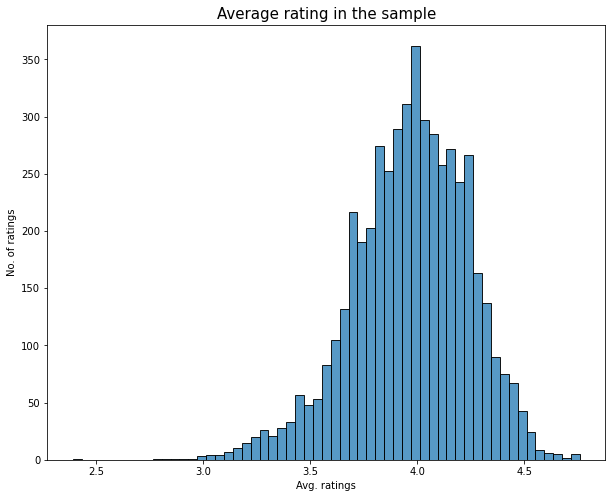

In [85]:
plt.figure(figsize=(10,8))

sns.histplot(data=books, x="average_rating")
plt.title('Average rating in the sample', fontsize=15)
plt.ylabel('No. of ratings')
plt.xlabel('Avg. ratings')

Average rating oscilates around 4.0 and is bell shaped. Books are skewed to the left which means than books tend to havehigher than lower ratings (which can be partially related to choosing only popular books).

In [94]:
popular_genres = books['genre'].value_counts().sort_values(ascending=False)[:9].index.tolist()

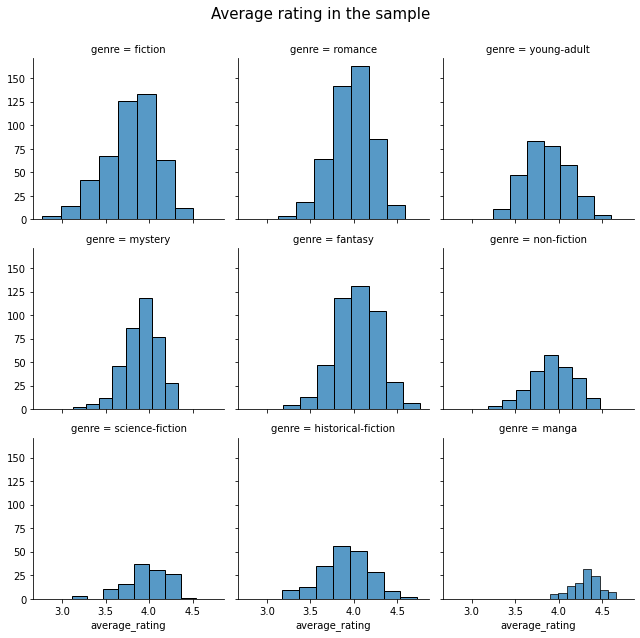

In [110]:
g = sns.FacetGrid(books[books['genre'].isin(popular_genres)], col="genre", height=3, col_wrap=3, sharex=True, sharey=True)
g.map(sns.histplot, "average_rating", bins=8)
plt.suptitle('Average rating in the sample', fontsize=15)
g.fig.subplots_adjust(top=.9)

We can see that some genres are moth rated near 4 and some near 3.

#### Ngram analysis in the book description

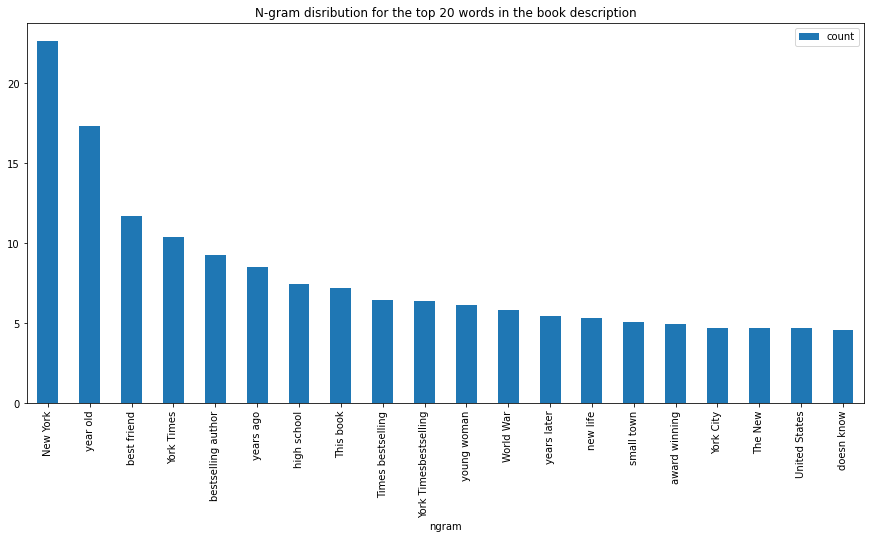

In [98]:
n_gram_plot(books['description'])

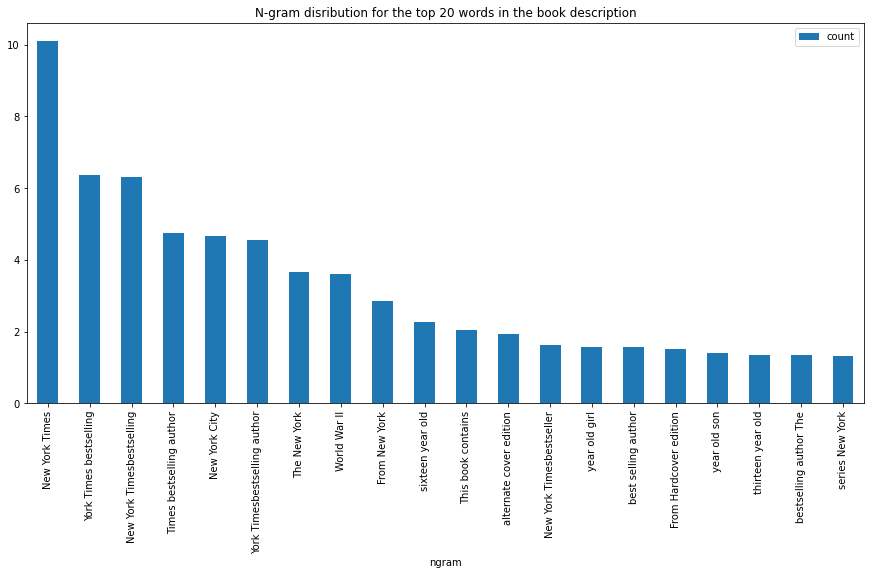

In [99]:
n_gram_plot(books['description'], ngram_range=(3, 3) )

Apparently majority of books have something to do with being the New York bestseller :)

In [100]:
### Convert Text
books['description_cln'] = books.description.apply(func=preprocess_text)

## Genres

That's the genres dataset (these tags are extracted from users' popular shelves by a simple keyword matching process) 

In [113]:
genres = pd.read_json(DIR + 'goodreads_book_genres_initial.json',lines=True)

In [114]:
### Transform Genres to get the most popular one
genres['main_genre'] = genres['genres'].apply(lambda t : max(t, key=t.get) if len(t.keys())>0 else 'unknown')

In [115]:
books['book_id'] = pd.to_numeric(books['book_id'])
books_genre = books.merge(genres, on ='book_id')

<AxesSubplot:>

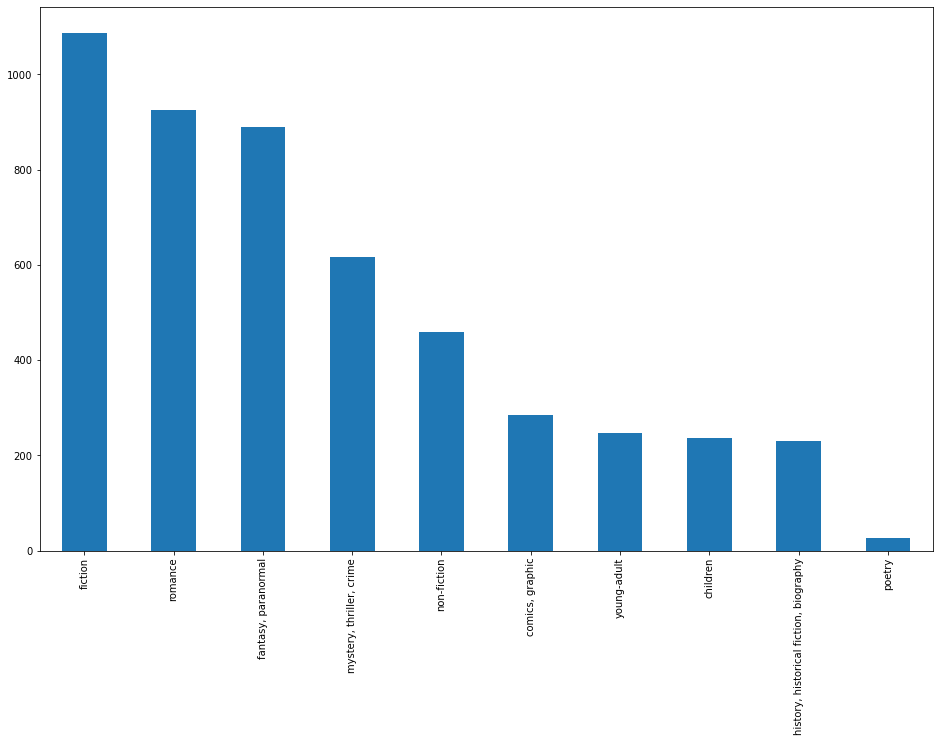

In [116]:
books_genre['main_genre'].value_counts().sort_values(ascending=False)[:15].plot(kind='bar', figsize=(16,10))

Representation of the particular genres is similar to the one int the previous method.

## Reviews

Since that's the heaviest dataset I am using only spoiler dataset used for the spoiler classification problem. It seems quite promising actually as it's should contain some books' plot description inside.

In [118]:
#reviews = load_data(os.path.join(DIR, 'goodreads_reviews_dedup.json.gz'), book_ids = books_ids)
reviews = load_data(os.path.join(DIR, 'goodreads_reviews_spoiler_raw.json.gz'), book_ids = books_ids)

In [119]:
reviews.head()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,8664353,da2d4cfce836a2c57ad55c38437aa692,5,"Wow. Amazing story, and well told - kept me up...",Sun Nov 20 09:10:15 -0800 2011,Wed Mar 22 11:47:04 -0700 2017,Wed May 16 00:00:00 -0700 2012,Sun May 06 00:00:00 -0700 2012,50,4
1,8842281e1d1347389f2ab93d60773d4d,14497,b8e08587ce1592d69548d0f644cb9893,4,** spoiler alert ** \n Just finished this and ...,Thu Mar 27 17:53:06 -0700 2008,Wed Mar 22 11:46:03 -0700 2017,Tue Oct 28 00:00:00 -0700 2008,,6,1
2,8842281e1d1347389f2ab93d60773d4d,18122,9a8c81912b6bf7f4091323a8093a94c8,4,** spoiler alert ** \n I absolutely loved the ...,Wed Dec 26 17:21:26 -0800 2007,Wed Mar 22 11:45:55 -0700 2017,Tue Jan 01 00:00:00 -0800 2008,,0,0
3,8842281e1d1347389f2ab93d60773d4d,2052,8b08f156b1fc6708aa7dceff1a000ab4,5,A classic LA detective novel - loved it. The o...,Mon Dec 18 11:10:25 -0800 2006,Wed Mar 22 11:44:51 -0700 2017,Tue May 01 00:00:00 -0700 2007,,3,2
4,8842281e1d1347389f2ab93d60773d4d,830,ae83b6910a6b2fa571745915af5b1a89,4,A really interesting novel that takes place in...,Mon Sep 04 12:05:38 -0700 2006,Thu May 08 11:43:24 -0700 2014,,,6,0


In [120]:
reviews['review_text_processed'] = reviews.review_text.apply(func=preprocess_text)

In [121]:
reviews['book_id'] = pd.to_numeric(reviews['book_id'])
book_reviews_genre = reviews.merge(books_genre, on='book_id')

In [122]:
book_reviews_genre.shape

(87734, 32)

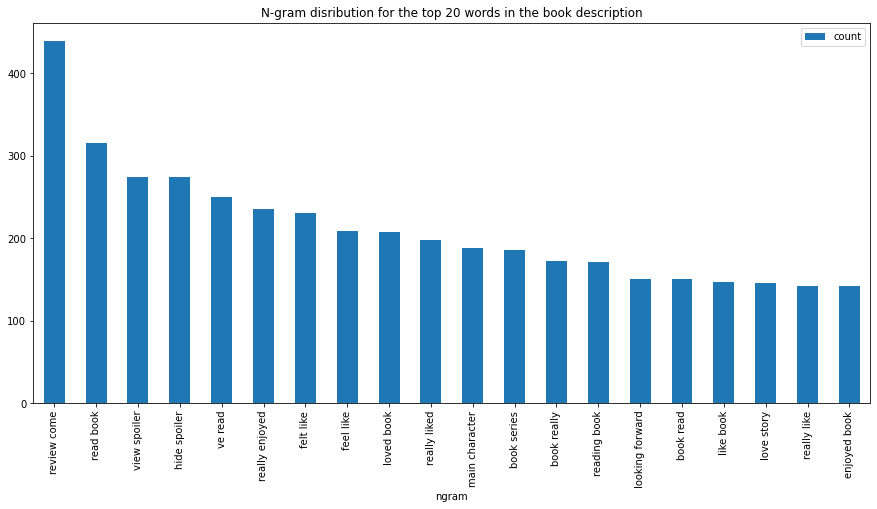

In [124]:
n_gram_plot(book_reviews_genre['review_text_processed'])

In [128]:
books_genre.sort_values(by='ratings_count', ascending=False)['title']

3847                    Mockingjay (The Hunger Games, #3)
3111                                            Jane Eyre
1550            Bridget Jones's Diary (Bridget Jones, #1)
4728    The Devil Wears Prada (The Devil Wears Prada, #1)
4345                    Me Before You (Me Before You, #1)
                              ...                        
2596    Bakuman, Volume 1: Dreams and Reality (Bakuman...
2950                                   Chobits, Omnibus 1
3026    The Story (NIV): The Bible as One Continuing S...
990                Wolverine: Origins, Volume 5: Deadpool
265                 Violet Tendencies (Sabina Kane, #2.5)
Name: title, Length: 5000, dtype: object

                                            title
615                              The Singles Game
0                            Best Friends Forever
1                                           Smoke
2                                      Petropolis
3                                 Burn (Pure, #3)
4                  Mermaid Moon (Sunset Cove, #2)
5    A Matter for Men (War Against the Chtorr #1)
6                                 On Chesil Beach
7                          The Mist in the Mirror


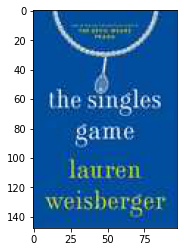

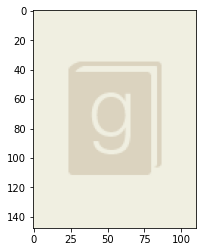

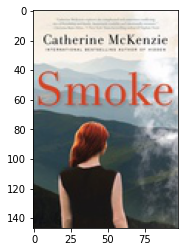

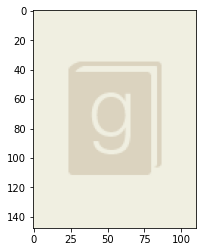

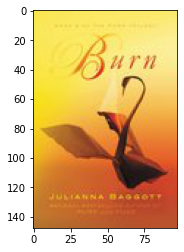

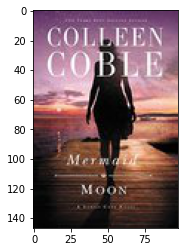

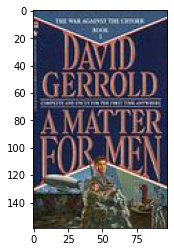

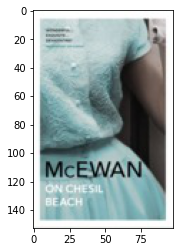

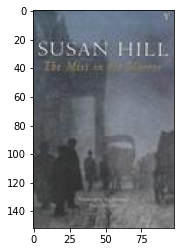

In [164]:
recommend_book_desc("The Devil Wears Prada (The Devil Wears Prada, #1)", show_covers=True)

                                                title
18        Keeping the Castle (Keeping the Castle, #1)
13                      Blackhearts (Blackhearts, #1)
19                  Something Wonderful (Sequels, #2)
2                           Outlander (Outlander, #1)
0   Unbroken: A World War II Story of Survival, Re...
6             And I Darken (The Conqueror's Saga, #1)
20                Whitney, My Love (Westmoreland, #2)
3                         The Haunting of Maddy Clare
1   Stalking Jack the Ripper (Stalking Jack the Ri...


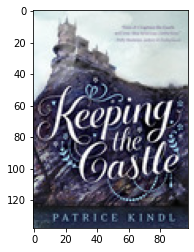

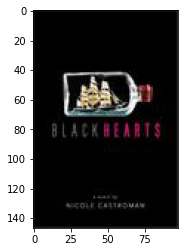

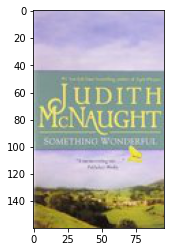

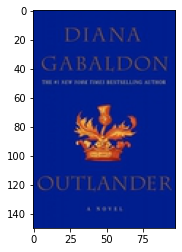

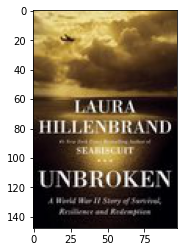

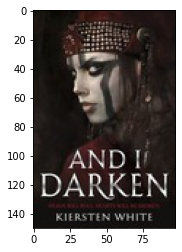

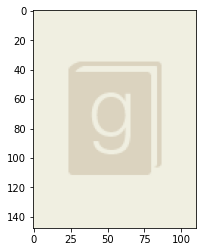

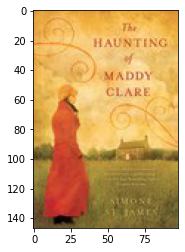

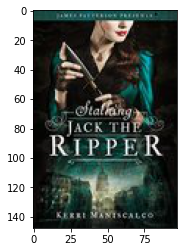

In [168]:
recommend_book_reviews("Jane Eyre", book_reviews_genre, show_covers=True)

In [136]:
for ix, i in enumerate(np.random.choice(book_reviews_genre['title'].unique(),10).tolist()):
    print("============= BOOK ",ix," =============")
    print("The most similar books by description for", i)
    recommend_book_desc(i)
    print("The most similar books by review for", i)
    recommend_book_reviews(i)

============= BOOK  0  =============
The most similar books by description for How to Live Safely in a Science Fictional Universe
                                          title
0                          Best Friends Forever
1                                         Smoke
2                                    Petropolis
3                               Burn (Pure, #3)
4                Mermaid Moon (Sunset Cove, #2)
5  A Matter for Men (War Against the Chtorr #1)
6                               On Chesil Beach
7                        The Mist in the Mirror
8                                      Our Game
The most similar books by review for How to Live Safely in a Science Fictional Universe
                                                 title
170                         The Man Who Folded Himself
108                      The Rise and Fall of D.O.D.O.
71   Just One Damned Thing After Another (The Chron...
41                            The Time Traveler's Wife
62                         